## Imports

In [3]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [4]:
def solve_2d_poisson_pure(p, pd, b, nx, ny, nt, dx, dy):
    
    row, col = p.shape
    # Source
    b[int(ny / 4), int(nx / 4)]  = 100
    b[int(3 * ny / 4), int(3 * nx / 4)] = -100
    
    
    for it in range(nt):
        for i in range(nx): pd[i] = p[i]
        for j in range(2, row):
            for i in range(2, col):
                p[j-1, i-1] = (((pd[j-1, i] + pd[j-1, i-2]) * dy**2 +
                                (pd[j, i-1] + pd[j-2, i-1]) * dx**2 -
                                b[j-1, i-1] * dx**2 * dy**2) / 
                                (2 * (dx**2 + dy**2)))
        p[0, :] = 0
        p[ny-1, :] = 0
        p[:, 0] = 0
        p[:, nx-1] = 0
        
    return 0

## Numba accelerator

In [5]:
@njit(fastmath=True)
def solve_2d_poisson_numba(p, pd, b, nx, ny, nt, dx, dy):
    
    row, col = p.shape
    # Source
    b[int(ny / 4), int(nx / 4)]  = 100
    b[int(3 * ny / 4), int(3 * nx / 4)] = -100
    
    
    for it in range(nt):
        for i in range(nx): pd[i] = p[i]
        for j in range(2, row):
            for i in range(2, col):
                p[j-1, i-1] = (((pd[j-1, i] + pd[j-1, i-2]) * dy**2 +
                                (pd[j, i-1] + pd[j-2, i-1]) * dx**2 -
                                b[j-1, i-1] * dx**2 * dy**2) / 
                                (2 * (dx**2 + dy**2)))
        p[0, :] = 0
        p[ny-1, :] = 0
        p[:, 0] = 0
        p[:, nx-1] = 0
        
    return 0

## Pyccel accelerator

In [6]:
@types('float[:,:]', 'float[:,:]','float[:,:]', 'int', 'int', 'int','float', 'float')
def solve_2d_poisson_pyccel(p, pd, b, nx, ny, nt, dx, dy):
    
    row, col = p.shape
    # Source
    b[int(ny / 4), int(nx / 4)]  = 100
    b[int(3 * ny / 4), int(3 * nx / 4)] = -100
    
    
    for it in range(nt):
        for i in range(nx): pd[i] = p[i]
        for j in range(2, row):
            for i in range(2, col):
                p[j-1, i-1] = (((pd[j-1, i] + pd[j-1, i-2]) * dy**2 +
                                (pd[j, i-1] + pd[j-2, i-1]) * dx**2 -
                                b[j-1, i-1] * dx**2 * dy**2) / 
                                (2 * (dx**2 + dy**2)))
        p[0, :] = 0
        p[ny-1, :] = 0
        p[:, 0] = 0
        p[:, nx-1] = 0
        
    return 0

## Inputs

Text(0.5, 0, '$y$')

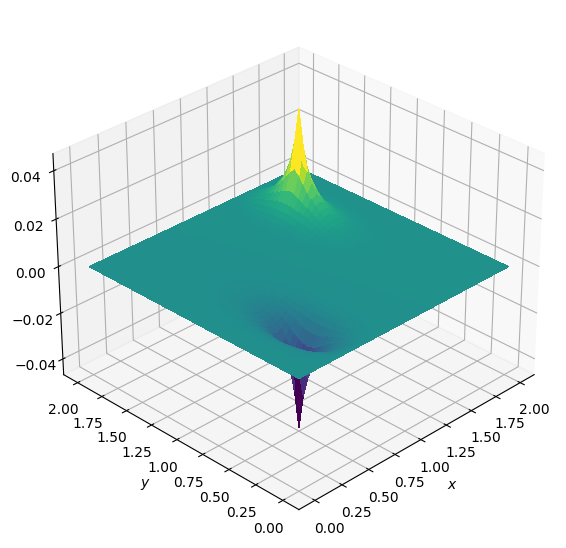

In [7]:
###variable declarations
nx = 50
ny = 50
nt  = 100
xmin = 0
xmax = 2
ymin = 0
ymax = 1

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

# Initialization
p  = np.zeros((ny, nx))
pd = np.zeros((ny, nx))
b  = np.zeros((ny, nx))
x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

solve_2d_poisson_pure(p, pd, b, nx, ny, nt, dx, dy)

fig = pyplot.figure(figsize=(10, 7), dpi=100)
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, p, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=False)
ax.view_init(30, 225)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

## Call Funtions

### Pure function

In [8]:
%timeit solve_2d_poisson_pure(p, pd, b, nx, ny, nt, dx, dy)

629 ms ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [9]:
%timeit solve_2d_poisson_numba(p, pd, b, nx, ny, nt, dx, dy)

1.44 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [10]:
solve_2d_poisson_f90 = epyccel(solve_2d_poisson_pyccel)

In [11]:
%timeit solve_2d_poisson_f90(p, pd, b, nx, ny, nt, dx, dy)

569 µs ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
